In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [4]:
# 1. 데이터 로드 및 탐색
df = pd.read_csv('machine.data_update.csv')
print(df.head())
print(df.info())
print(df.describe())

# 2. 범주형 데이터 변환
df = pd.get_dummies(df, drop_first=True)
print(df.head())
print(df.info())

# 3. 타겟 변수 및 특성 선택
X = df.drop('PRP', axis=1)
y = df['PRP']

# 4. 데이터 표준화 및 다항 회귀 포함
num_features = X.columns

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ]), num_features)
])

  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0    adviser     32/60   125   256   6000   256     16    128  198  199
1     amdahl    470v/7    29  8000  32000    32      8     32  269  253
2     amdahl   470v/7a    29  8000  32000    32      8     32  220  253
3     amdahl   470v/7b    29  8000  32000    32      8     32  172  253
4     amdahl   470v/7c    29  8000  16000    32      8     16  132  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 no

In [6]:
# 5. 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. 모델 정의 및 앙상블 학습 과정
models = [('lr', LinearRegression()), ('sgd', SGDRegressor())]
ensemble = VotingRegressor(estimators=models)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# 7. 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'ERP',
       'VendorName_amdahl', 'VendorName_apollo', 'VendorName_basf',
       ...
       'ModelName_v8635', 'ModelName_v8650', 'Mo...
       'ModelName_v8665', 'ModelName_v8670', 'ModelName_vax:11/730',
       'ModelName_vax:11/750', 'ModelName_vax:11/780', 'ModelName_vs-100',
       'ModelName_vs-90'],
      dtype='object', length=244))])),
                                       ('ensemble',
                                        VotingRegressor(estimators=[('lr',
                                                                     LinearRegression()),
                                                                    ('sgd',
                                                                     SGDRegressor())]))]),
             param_grid={'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
                         'ensemble__sgd__max_iter': [1000, 2000, 3000]},
             scoring='r2')

Best parameters found: {'ensemble__sgd__alpha': 1.0, 'ensemble__sgd__max_iter': 2000}
Cross-validated RMSE: 1984481.5818255148
Training MSE: 1766982692009793.2, MAE: 27318201.875825968, R^2: -91913297903.25517
Test MSE: 847036354805350.2, MAE: 14549508.362257382, R^2: -16638945484.397366


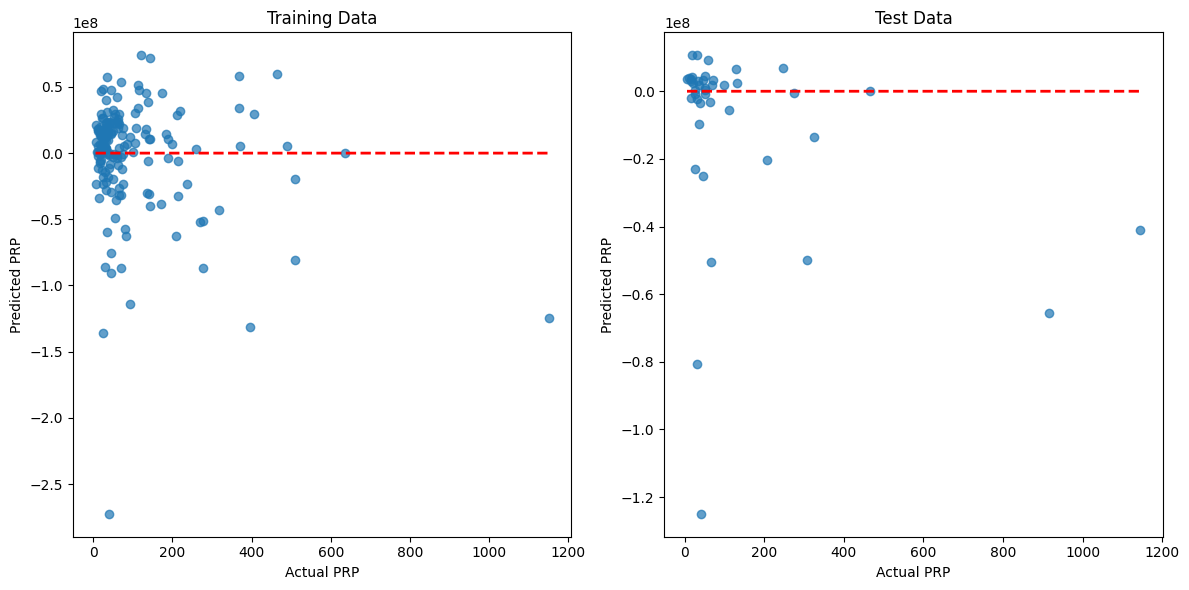

In [7]:
# 8. 모델 평가
print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Training MSE: {train_mse}, MAE: {train_mae}, R^2: {train_r2}')
print(f'Test MSE: {test_mse}, MAE: {test_mae}, R^2: {test_r2}')

# 9. 결과 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Training Data')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Test Data')

plt.tight_layout()
plt.savefig('machine.data_performance_prediction.png')
plt.show()


(2)번 문제

In [9]:
# 데이터 로드 및 탐색
df = pd.read_csv('machine.data_update.csv')
df = pd.get_dummies(df, drop_first=True)

# 타겟 변수 및 특성 선택
X = df.drop('PRP', axis=1)
y = df['PRP']

# 데이터 표준화 및 다항 회귀 포함
num_features = X.columns
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ]), num_features)
])


In [10]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의 및 앙상블 학습 과정
models = [('lr', LinearRegression()), ('sgd', SGDRegressor())]
ensemble = VotingRegressor(estimators=models)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])


In [11]:
# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha': [0.0001, 0.1, 1.0],
    'ensemble__sgd__max_iter': [1000, 2000, 3000]
}
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 최적 모델
best_model = grid_search.best_estimator_


In [12]:
# 교차 검증 점수 계산
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

# 학습 데이터와 테스트 데이터에 대해 예측 수행
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [13]:
# 성능 지표 계산
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [14]:
# 결과 출력
print(f"Best parameters found: {grid_search.best_params_}")
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

print(f'Training MSE: {train_mse}')
print(f'Training MAE: {train_mae}')
print(f'Training R^2: {train_r2}')

print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R^2: {test_r2}')

Best parameters found: {'ensemble__sgd__alpha': 1.0, 'ensemble__sgd__max_iter': 3000}
Cross-validated RMSE: 2992164.4918529615
Training MSE: 3138640682359292.0
Training MAE: 31879144.64456146
Training R^2: -163262955180.51318
Test MSE: 5755076546171756.0
Test MAE: 26529568.92222037
Test R^2: -113051115659.84572


In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor

(3)번 문제

In [ ]:
# 모델 정의 및 앙상블 학습 과정
models = [
    ('lr', Ridge()),
    ('lasso', Lasso()),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor())
]
ensemble = VotingRegressor(estimators=models)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])


In [ ]:

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__lr__alpha': [0.1, 1.0, 10.0],
    'ensemble__lasso__alpha': [0.0001, 0.001, 0.01, 0.1],
    'ensemble__rf__n_estimators': [50, 100, 200],
    'ensemble__gbr__n_estimators': [50, 100, 200],
    'ensemble__gbr__learning_rate': [0.01, 0.1, 0.2],
    'ensemble__gbr__max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.062e+02, tolerance: 1.499e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.669e+02, tolerance: 3.000e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [ ]:
# 최적 모델
best_model = grid_search.best_estimator_

# 교차 검증 점수 계산
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

# 학습 데이터와 테스트 데이터에 대해 예측 수행
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 성능 지표 계산
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)


In [ ]:
# 결과 출력
print(f"Best parameters found: {grid_search.best_params_}")
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

print(f'Training MSE: {train_mse}')
print(f'Training MAE: {train_mae}')
print(f'Training R^2: {train_r2}')

print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R^2: {test_r2}')

(4)번 문제

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor

# 데이터 불러오기
df = pd.read_csv('machine.data.csv')

# 데이터 전처리
df = pd.get_dummies(df, drop_first=True)
X = df.drop('PRP', axis=1)
y = df['PRP']

# 다항 특성 생성 및 표준화
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=42)

# 각 모델 정의
models = [
    ('lr', Ridge()),
    ('lasso', Lasso()),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor())
]

# 앙상블 모델 정의
ensemble = VotingRegressor(estimators=models)

# 파이프라인 구성
model_pipeline = Pipeline(steps=[
    ('ensemble', ensemble)
])

# 하이퍼파라미터 튜닝을 위한 그리드 서치
param_grid = {
    'ensemble__lr__alpha': [0.1, 1.0, 10.0],
    'ensemble__lasso__alpha': [0.0001, 0.001, 0.01, 0.1],
    'ensemble__rf__n_estimators': [50, 100, 200],
    'ensemble__gbr__n_estimators': [50, 100, 200],
    'ensemble__gbr__learning_rate': [0.01, 0.1, 0.2],
    'ensemble__gbr__max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 최적 모델
best_model = grid_search.best_estimator_

# 교차 검증 점수 계산
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

# 학습 데이터와 테스트 데이터에 대해 예측 수행
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 성능 지표 계산
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 결과 출력
print(f"Best parameters found: {grid_search.best_params_}")
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

print(f'Training MSE: {train_mse}')
print(f'Training MAE: {train_mae}')
print(f'Training R^2: {train_r2}')

print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R^2: {test_r2}')

# 결과 데이터프레임에 저장
results1 = {
    'Model': ['Ensemble'],
    'Data': ['Training', 'Training', 'Training', 'Test', 'Test', 'Test'],
    'Metric': ['MSE', 'MAE', 'R^2', 'MSE', 'MAE', 'R^2'],
    'Score': [train_mse, train_mae, train_r2, test_mse, test_mae, test_r2]
}

df_results1 = pd.DataFrame(results1)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso

# 데이터 불러오기
df = pd.read_csv('machine.data.csv')

# 데이터 전처리
df = pd.get_dummies(df, drop_first=True)
X = df.drop('PRP', axis=1)
y = df['PRP']

# 다항 특성 생성 및 표준화
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.2, random_state=42)

# 각 모델 정의
models = [
    ('lr', Ridge()),
    ('lasso', Lasso()),
    ('rf', RandomForestRegressor()),
    ('gbr', GradientBoostingRegressor())
]
ensemble = VotingRegressor(estimators=models)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble)
])

# 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__lr__alpha': [0.1, 1.0, 10.0],
    'ensemble__lasso__alpha': [0.0001, 0.001, 0.01, 0.1],
    'ensemble__rf__n_estimators': [50, 100, 200],
    'ensemble__gbr__n_estimators': [50, 100, 200],
    'ensemble__gbr__learning_rate': [0.01, 0.1, 0.2],
    'ensemble__gbr__max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 최적 모델
best_model = grid_search.best_estimator_

# 교차 검증 점수 계산
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

# 학습 데이터와 테스트 데이터에 대해 예측 수행
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 성능 지표 계산
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# 결과 출력
print(f"Best parameters found: {grid_search.best_params_}")
print(f'Cross-validated RMSE: {cv_rmse.mean()}')

print(f'Training MSE: {train_mse}')
print(f'Training MAE: {train_mae}')
print(f'Training R^2: {train_r2}')

print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R^2: {test_r2}')

# 결과 데이터프레임에 저장
results2 = {
    'Model': ['Ensemble'],
    'Data': ['Training', 'Training', 'Training', 'Test', 'Test', 'Test'],
    'Metric': ['MSE', 'MAE', 'R^2', 'MSE', 'MAE', 'R^2'],
    'Score': [train_mse, train_mae, train_r2, test_mse, test_mae, test_r2]
}

df_results2 = pd.DataFrame(results2)


In [ ]:
# 두 결과 데이터프레임을 합치기
df_results = pd.concat([df_results1, df_results2])

# 바 차트로 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Score', hue='Data', data=df_results, ci=None)
plt.title('Performance Metrics Comparison')
plt.legend(title='Dataset', loc='upper left')
plt.ylabel('Score')
plt.show()
